<a href="https://colab.research.google.com/github/dinhanhthi/data-science-learning/blob/master/playground/HOG_histogram_oriented_gradient_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histogram Oriented gradient

Article + source (Vietnamese): https://phamdinhkhanh.github.io/2019/11/22/HOG.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import sys
colab_notebook = '/content/gdrive/My Drive/Colab Notebooks'
sys.path.append(colab_notebook + '/INSTALLED_LIBS/')
data_dir = colab_notebook + '/DATA/'

image shape: (407, 800, 3)
gray shape:  (407, 800)


Text(0.5, 1.0, 'Gray Image')

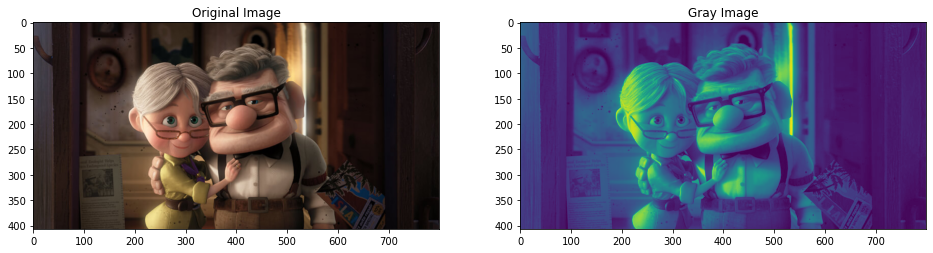

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = plt.imread(data_dir + 'img.jpeg', cv2.IMREAD_UNCHANGED)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('image shape:', img.shape)
print('gray shape: ', gray.shape)

plt.figure(figsize = (16, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(gray)
plt.title('Gray Image')

In [9]:
# Calculate gradient gx, gy
gx = cv2.Sobel(gray, cv2.CV_32F, dx=0, dy=1, ksize=3)
gy = cv2.Sobel(gray, cv2.CV_32F, dx=1, dy=0, ksize=3)

print('gray shape: {}'.format(gray.shape))
print('gx shape: {}'.format(gx.shape))
print('gy shape: {}'.format(gy.shape))

gray shape: (407, 800)
gx shape: (407, 800)
gy shape: (407, 800)


In [10]:
g, theta = cv2.cartToPolar(gx, gy, angleInDegrees=True) 
print('gradient format: {}'.format(g.shape))
print('theta format: {}'.format(theta.shape))

gradient format: (407, 800)
theta format: (407, 800)


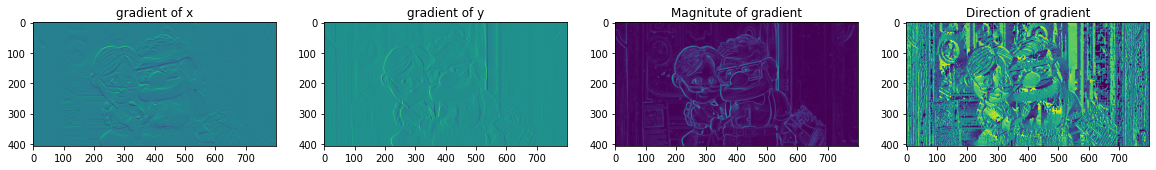

In [14]:
w = 20
h = 10

plt.figure(figsize=(w, h))
plt.subplot(1, 4, 1)
plt.title('gradient of x')
plt.imshow(gx)

plt.subplot(1, 4, 2)
plt.title('gradient of y')
plt.imshow(gy)

plt.subplot(1, 4, 3)
plt.title('Magnitute of gradient')
plt.imshow(g)

plt.subplot(1, 4, 4)
plt.title('Direction of gradient')
plt.imshow(theta)

## Calculate HOG

In [15]:
print('Kích thước ảnh gốc: ', img.shape)

Kích thước ảnh gốc:  (407, 800, 3)


In [17]:
# 1. Khai báo các tham số
cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# 2. Tính toán các tham số truyền vào HOGDescriptor
# winSize: Kích thước của bức ảnh được crop để chia hết cho cell size.
winSize = (img.shape[1] // cell_size[1] * cell_size[1], img.shape[0] // cell_size[0] * cell_size[0])
# blockSize: Kích thước của 1 block
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
# blockStride: Số bước di chuyển của block khi thực hiện chuẩn hóa histogram bước 3
blockStride = (cell_size[1], cell_size[0])
print('Kích thước bức ảnh crop theo winSize (pixel): ', winSize)
print('Kích thước của 1 block (pixel): ', blockSize)
print('Kích thước của block stride (pixel): ', blockStride)

# 3. Compute HOG descriptor
hog = cv2.HOGDescriptor(_winSize=winSize,
                        _blockSize=blockSize,
                        _blockStride=blockStride,
                        _cellSize=cell_size,
                        _nbins=nbins)

# Kích thước của lưới ô vuông.
n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
print('Kích thước lưới ô vuông (ô vuông): ', n_cells)

# Reshape hog feature
hog_feats = hog.compute(img)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  

print('Kích thước hog feature (h, w, block_size_h, block_size_w, nbins): ', hog_feats.shape)

Kích thước bức ảnh crop theo winSize (pixel):  (800, 400)
Kích thước của 1 block (pixel):  (16, 16)
Kích thước của block stride (pixel):  (8, 8)
Kích thước lưới ô vuông (ô vuông):  (50, 100)
Kích thước hog feature (h, w, block_size_h, block_size_w, nbins):  (49, 99, 2, 2, 9)


## HOG feature descriptor

In [19]:
from skimage import feature
H = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")

print('Kích thước hog features: ', H.shape)

Kích thước hog features:  (174636,)


Ngoài ra trong skimage chúng ta còn cho phép biểu diễn hình ảnh của phân phối HOG trên bức ảnh như sau:

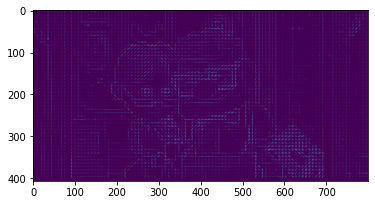

In [20]:
from skimage import exposure
from skimage import feature
import cv2
import matplotlib.pyplot as plt
 
(H, hogImage) = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2",
    visualize=True)

hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
hogImage = hogImage.astype("uint8")
 
plt.imshow(hogImage)

## Application: human detection

In [4]:
from __future__ import print_function
from imutils.object_detection import non_max_suppression
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2

In [5]:
# Khởi tạo một bộ mô tả đặc trưng HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [6]:
data_dir

'/content/gdrive/My Drive/Colab Notebooks/DATA/'

weights:  [[1.9608571 ]
 [2.55448514]]
rects:  (2, 4)
[INFO] /content/gdrive/My Drive/Colab Notebooks/DATA/two_walking.jpeg: 2 original boxes, 2 after suppression


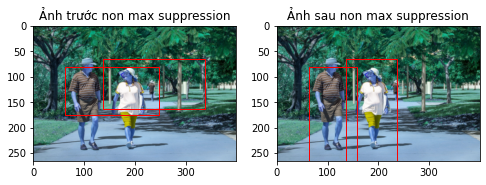

In [12]:
import glob
import matplotlib.patches as patches
import cv2
import imutils
import matplotlib.pyplot as plt

imagePath = data_dir + "two_walking.jpeg"
image = cv2.imread(imagePath)
image = imutils.resize(image, width = min(400, image.shape[1]))
orig = image.copy()

plt.figure(figsize = (8, 6))
# 1. Bounding box với ảnh gốc
# Khởi tạo plot
ax1 = plt.subplot(1, 2, 1)

# Phát hiện người trong ảnh
(rects, weights) = hog.detectMultiScale(img = image, winStride = (4, 4),
                                        padding = (8, 8), scale = 1.05)
print('weights: ', weights)
# Vẽ các bounding box xung quanh ảnh gốc
for (x, y, h, w) in rects:
  # cv2.rectangle(orig, (x, y), (x+w, y+h), (0, 0, 255), 2)
  rectFig = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
  ax1.imshow(orig)
  ax1.add_patch(rectFig)
  plt.title('Ảnh trước non max suppression')

rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
print('rects: ', rects.shape)
# Sử dụng non max suppression để lấy ra bounding box cuối cùng với ngưỡng threshold = 0.65
pick = non_max_suppression(rects, probs = None, overlapThresh=0.65)

# 2. Bounding box với ảnh suppression
# Khởi tạo plot
ax2 = plt.subplot(1, 2, 2)
# Vẽ bounding box cuối cùng trên ảnh
for (xA, yA, xB, yB) in pick:
  w = xB-xA
  h = yB-yA
  # cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)
  # Hiển thị hình ảnh
  plt.imshow(image)
  plt.title('Ảnh sau non max suppression')
  rectFig = patches.Rectangle((xA, yA),w,h,linewidth=1,edgecolor='r',facecolor='none')
  ax2.add_patch(rectFig)
    
# Lấy thông tin ảnh
filename = imagePath[imagePath.rfind("\\") + 1:]
print("[INFO] {}: {} original boxes, {} after suppression".format(
    filename, len(rects), len(pick)))

# cv2.imshow("Before NMS", orig)
# cv2.imshow("After NMS", image)
# cv2.waitKey(0)